# **TP Python : Fouille et Visualisation de Données Massives**

Par ANANOU Kokou Germain

---------------------------------------

### Introduction

Dans le cadre de ce TP qui est aussi une cette compétition Kaggle, l’objectif est de construire un modèle de machine learning capable de prédire si un passager a survécu ou non en fonction de certaines caractéristiques telles que son sexe, son âge, sa classe de voyage et d’autres informations disponibles.

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os

## Partie 1 : Exploration et Préparation des Données

### 1.1 - Chargement des Données

Le dataset Titanic, bien qu’accessible publiquement, requiert une authentification pour être téléchargé depuis Kaggle. Cette restriction est une spécificité de la plateforme. Afin de simplifier l’accès aux données sans authentification, j’ai téléchargé le dataset depuis un raw Github de Michael Waskom sur GitHub.
Ainsi, le chargement des données se fera directement à partir du lien raw.

In [2]:
#Verifie si le fichier existe en local

if os.path.exists('titanic.csv'):
    df_titanic = pd.read_csv('titanic.csv')
    
#Chargement du dataset Titanic de Seaborn
else:
    url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"
    df_titanic = pd.read_csv(url)

### 1.2 - Exploration des Données

In [3]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# Infomations sur les variables d'entrainement et leurs structures
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [5]:
#Taille de l'echantillon d'entrainement 
df_titanic.shape

(891, 15)

Le Dataset contient 12 variables avec 891 observations pour le jeux d'entainement.Les variables sont les suivantes:


- **survived**: Indique si le passager a survécu (1 = Oui, 0 = Non)
- **pclass**: Classe du passager (1 = Première, 2 = Deuxième, 3 = Troisième)
- **sex**: Sexe du passager (Homme ou femme)
- **age**: Age du passager en années
- **sibsp**: Nombre de frères/sœurs et conjoint(e) à bord
- **parch**: Nombre de parents/enfants à bord
- **fare**: Prix du billet
- **embarked**: Port d’embarquement (C = Cherbourg, Q = Queenstown, S = Southampton)
- **class**: Classe du billet sous forme de texte ('First', 'Second', 'Third')
- **who**: Catégorie du passager (man, woman, child
- **adult_male**: Indique si le passager est un homme adulte (True/False).
- **deck**: Pont où se trouvait la cabine du passager
- **alive**: contient des valeurs textuelles "yes" et "no", indiquant si le passager a survécu ou non
- **alone** : Booléen indiquant si le passager voyageait seul

In [6]:
# Statistiques descriptives des variables numériques
df_titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.3 - Nettoyage des Données

In [7]:
# Verification des valeurs manquantes dans les variables
print(f"\nValeurs manquantes par variables :")
print((df_titanic.isnull().sum()/df_titanic.shape[0])*100)


Valeurs manquantes par variables :
survived        0.000000
pclass          0.000000
sex             0.000000
age            19.865320
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.224467
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.216611
embark_town     0.224467
alive           0.000000
alone           0.000000
dtype: float64


- La variable Cabin a un très fort taux de valeurs manquantes (77.1%), nous allons l'exclure du plan de travail.
- La variable Age a environ 20% de valeurs manquantes, nous allons les remplacer avec la valeure mediane.
- Embarked n’a que 2 valeurs manquantes, on les remplace avec la valeur la plus fréquente.

In [8]:
# Suppression de la colonne Cabin
df_titanic = df_titanic.drop('deck', axis=1)

In [9]:
# Remplacement des valeurs manquantes de Age par la médiane
age_median = df_titanic['age'].median()
df_titanic['age'] = df_titanic['age'].fillna(age_median)

In [10]:
# Remplacement des valeurs manquantes de Embarked par le mode (valeur la plus fréquente)
embarked_mode = df_titanic['embarked'].mode()[0]
df_titanic['embarked'] = df_titanic['embarked'].fillna(embarked_mode)

embark_mode = df_titanic['embark_town'].mode()[0]
df_titanic['embark_town'] = df_titanic['embark_town'].fillna(embark_mode)

In [11]:
# Verification des valeurs manquantes dans les variables
print(f"\nValeurs manquantes par variables :")
print((df_titanic.isnull().sum()/df_titanic.shape[0])*100)


Valeurs manquantes par variables :
survived       0.0
pclass         0.0
sex            0.0
age            0.0
sibsp          0.0
parch          0.0
fare           0.0
embarked       0.0
class          0.0
who            0.0
adult_male     0.0
embark_town    0.0
alive          0.0
alone          0.0
dtype: float64


In [12]:
# Verification des valeurs NaN dans les variables
print(f"\nValeurs manquantes NaN par variables :")
print((df_titanic.isna().sum()/df_titanic.shape[0])*100)


Valeurs manquantes NaN par variables :
survived       0.0
pclass         0.0
sex            0.0
age            0.0
sibsp          0.0
parch          0.0
fare           0.0
embarked       0.0
class          0.0
who            0.0
adult_male     0.0
embark_town    0.0
alive          0.0
alone          0.0
dtype: float64


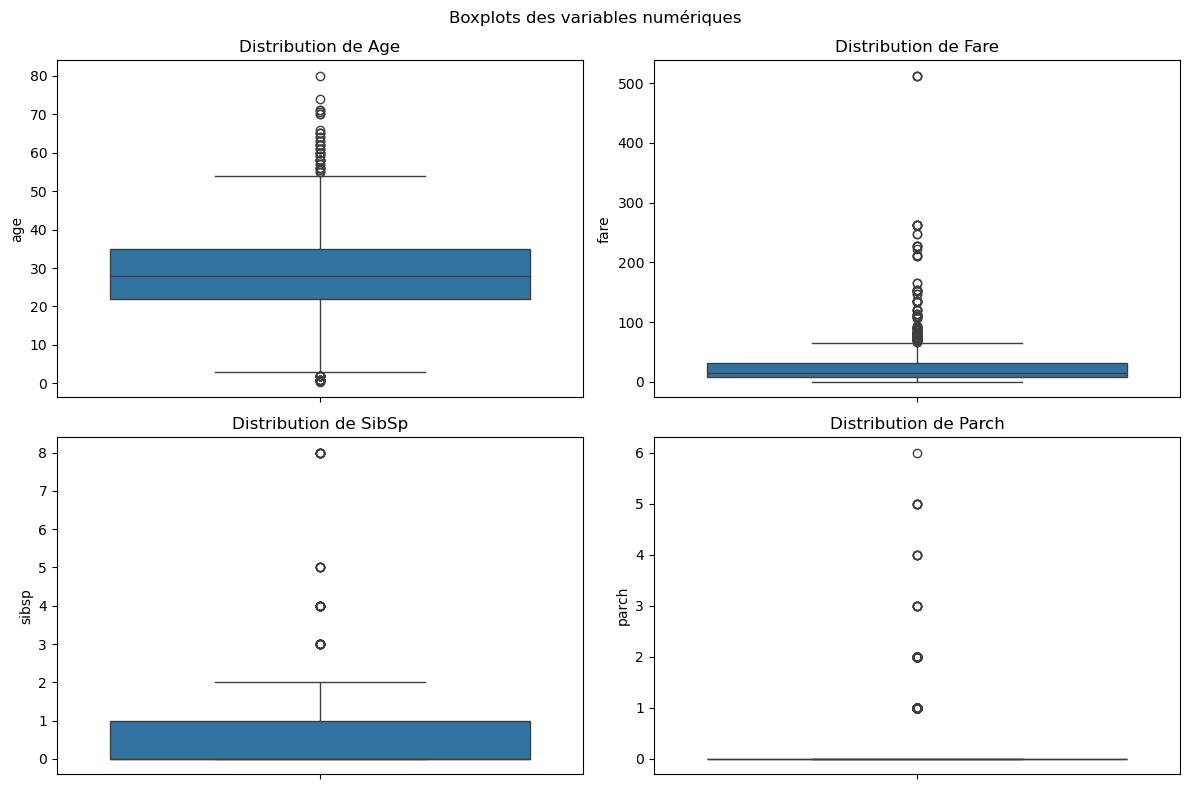

In [13]:
# Création des boxplots pour analyse des outliers des variables numeriques
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Boxplots des variables numériques')

# Age
sns.boxplot(data=df_titanic, y='age', ax=axes[0,0])
axes[0,0].set_title('Distribution de Age')

# Fare
sns.boxplot(data=df_titanic, y='fare', ax=axes[0,1])
axes[0,1].set_title('Distribution de Fare')

# SibSp
sns.boxplot(data=df_titanic, y='sibsp', ax=axes[1,0])
axes[1,0].set_title('Distribution de SibSp')

# Parch
sns.boxplot(data=df_titanic, y='parch', ax=axes[1,1])
axes[1,1].set_title('Distribution de Parch')

plt.tight_layout()
plt.show()

**Analyse des boxplots**
- **Age**
   - La médiane est autour de 28-30 ans
   - On observe des outliers au-delà de 60-70 ans
- **Fare (prix du billet)**
   - Beaucoup d'outliers vers le haut
   - Certains passagers ont certainement payé des sommes très élevées
- **SibSp (nombre de frères/sœurs/époux)**
   - La majorité des passagers voyageaient avec soit 0 ou 1 membre de famille
- **Parch (nombre de parents/enfants)**
   - La plupart des passagers n'avaient certainement pas d'enfants/parents

### 1.4 - Standardisation et categorisation des données

In [14]:
# Séparation des variables numériques et catégoriques
numeric_features = ['age', 'fare']

In [15]:
# Standardisation des variables numériques
scaler = StandardScaler()
df_titanic[numeric_features] = scaler.fit_transform(df_titanic[numeric_features])

In [16]:
# Encodage des variables catégoriques
# Encodage binaire (0/1) pour sex
df_titanic['sex'] = df_titanic['sex'].map({'male': 1, 'female': 0})

In [17]:
#Encodage one-hot pour embarked et pclass
df_titanic = pd.get_dummies(df_titanic, columns=['embarked', 'pclass'], drop_first=True)

In [18]:
# Verification des valeurs manquantes dans les variables
print(f"\nValeurs manquantes par variables :")
print((df_titanic.isnull().sum()/df_titanic.shape[0])*100)


Valeurs manquantes par variables :
survived       0.0
sex            0.0
age            0.0
sibsp          0.0
parch          0.0
fare           0.0
class          0.0
who            0.0
adult_male     0.0
embark_town    0.0
alive          0.0
alone          0.0
embarked_Q     0.0
embarked_S     0.0
pclass_2       0.0
pclass_3       0.0
dtype: float64


In [19]:
# Vérification du résultat
print("Colonnes après standardisation :")
print(df_titanic.columns.tolist())

Colonnes après standardisation :
['survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone', 'embarked_Q', 'embarked_S', 'pclass_2', 'pclass_3']


In [20]:
# Suppression des colonnes non pertinentes
df_titanic = df_titanic.drop(columns=['class', 'who', 'alive', 'embark_town'])

## Partie 2 : Fouille des Données

### 2.1 - Analyse Exploratoire

In [21]:
# Statistiques descriptives des variables numériques
df_titanic.describe()

,survived,sex,age,sibsp,parch,fare
count,891.000000,891.000000,8.910000e+02,891.000000,891.000000,8.910000e+02
mean,0.383838,0.647587,2.272780e-16,0.523008,0.381594,3.987333e-18
std,0.486592,0.477990,1.000562e+00,1.102743,0.806057,1.000562e+00
min,0.000000,0.000000,-2.224156e+00,0.000000,0.000000,-6.484217e-01
25%,0.000000,0.000000,-5.657365e-01,0.000000,0.000000,-4.891482e-01
50%,0.000000,1.000000,-1.046374e-01,0.000000,0.000000,-3.573909e-01
75%,1.000000,1.000000,4.333115e-01,1.000000,0.000000,-2.424635e-02
max,1.000000,1.000000,3.891554e+00,8.000000,6.000000,9.667167e+00


In [22]:
# Analyse de la corrélation entre les variables
correlation_matrix = df_titanic.corr()

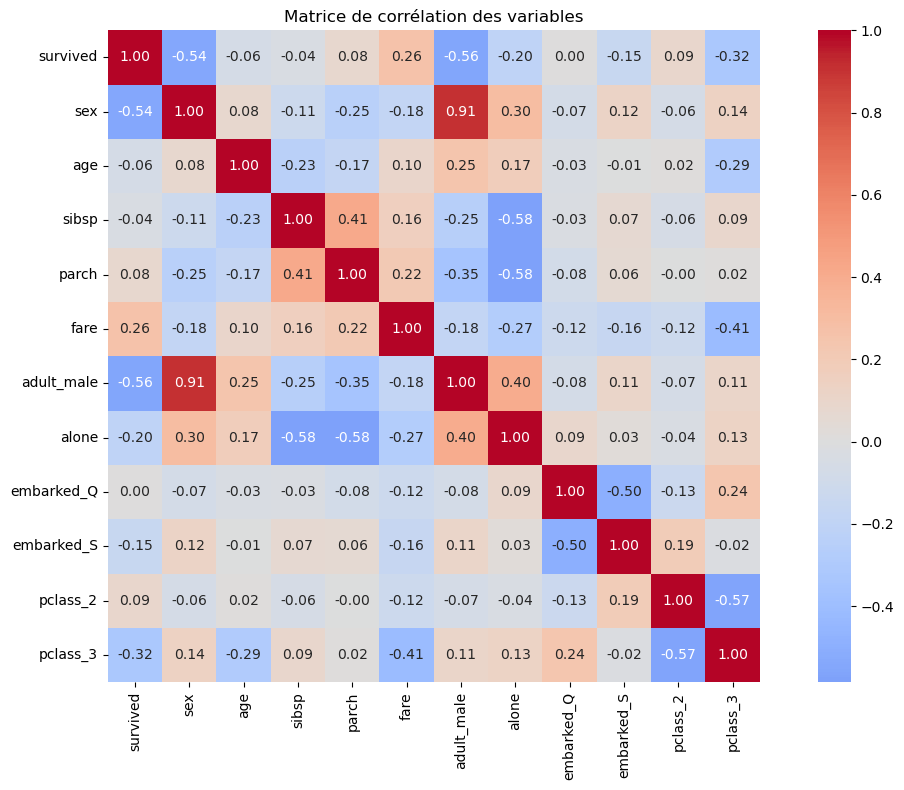

In [23]:
# Création d'une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True,           # Affiche les valeurs
            cmap='coolwarm',      # Palette de couleurs
            center=0,             # Centre la colormap à 0
            fmt='.2f',           # Format à 2 décimales
            square=True)          # Cellules carrées

plt.title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()


In [24]:
# Identification des corrélations importantes avec Survived
survival_correlations = correlation_matrix['survived'].sort_values(ascending=False)
print("\nCorrélations avec la survie (triées) :")
print(survival_correlations)


Corrélations avec la survie (triées) :
survived      1.000000
fare          0.257307
pclass_2      0.093349
parch         0.081629
embarked_Q    0.003650
sibsp        -0.035322
age          -0.064910
embarked_S   -0.149683
alone        -0.203367
pclass_3     -0.322308
sex          -0.543351
adult_male   -0.557080
Name: survived, dtype: float64


| Variable         | Corrélation avec Survived | Interprétation                                                                 |
|-------------------|--------------------------|-------------------------------------------------------------------------------|
| fare              | (+0.257)                | Les passagers ayant payé un tarif plus élevé avaient plus de chances de survivre (probablement en 1ère classe). |
| pclass_2          | (+0.093)                | Être en 2ᵉ classe est légèrement associé à une meilleure survie.             |
| parch             | (+0.081)                | Avoir des membres de la famille à bord augmente un peu les chances de survie. |
| sex               | (-0.543)                | Les femmes ont beaucoup plus survécu que les hommes (les hommes étant codés 1, la corrélation est négative). |
| adult_male        | (-0.557)                | Les hommes adultes ont encore moins survécu que les autres groupes (enfants et femmes prioritaires). |
| pclass_3         | (-0.322)                | Les passagers de 3ᵉ classe ont eu moins de chances de survie.                |
| alone             | (-0.203)                | Voyager seul réduit les chances de survie.                                     |
| embarked_S        | (-0.149)                | Ceux qui ont embarqué à Southampton ont eu moins de chances de survivre.     |
| age               | (-0.064)                | L’âge n’a pas une forte corrélation avec la survie, mais les jeunes enfants ont été favorisés. |

In [25]:
# Identification des corrélations fortes (>0.5 ou <-0.5)
threshold = 0.5
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            strong_correlations.append((
                correlation_matrix.index[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("\nCorrélations fortes (>0.5 ou <-0.5) :")
for var1, var2, corr in strong_correlations:
    print(f"{var1} - {var2}: {corr:.3f}")


Corrélations fortes (>0.5 ou <-0.5) :
sex - survived: -0.543
adult_male - survived: -0.557
adult_male - sex: 0.909
alone - sibsp: -0.584
alone - parch: -0.583
pclass_3 - pclass_2: -0.565


| Variables Corrélées | Corrélation | Explication                                                                      |
|----------------------|--------------|----------------------------------------------------------------------------------|
| sex - survived       | -0.543       | Les hommes ont moins survécu que les femmes (priorité aux femmes et enfants).     |
| adult_male - survived | -0.557       | Les hommes adultes ont encore moins survécu que les autres groupes.                 |
| adult_male - sex      | +0.909       | Fortement lié car adult_male = True pour les hommes adultes uniquement.           |
| alone - sibsp        | -0.584       | Voyager seul signifie 0 frères/sœurs/conjoints à bord (relation négative).       |
| alone - parch        | -0.583       | Voyager seul signifie 0 parents/enfants à bord.                                 |
| pclass_3 - pclass_2  | -0.565       | Les passagers de 3ᵉ classe sont moins nombreux en 2ᵉ classe (relation négative logique). |

### 2.2 -  Algorithme de Clustering

#### 2.2.1 - CLustering des donnees

In [26]:
# Sélection des colonnes numériques

In [27]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   sex         891 non-null    int64  
 2   age         891 non-null    float64
 3   sibsp       891 non-null    int64  
 4   parch       891 non-null    int64  
 5   fare        891 non-null    float64
 6   adult_male  891 non-null    bool   
 7   alone       891 non-null    bool   
 8   embarked_Q  891 non-null    bool   
 9   embarked_S  891 non-null    bool   
 10  pclass_2    891 non-null    bool   
 11  pclass_3    891 non-null    bool   
dtypes: bool(6), float64(2), int64(4)
memory usage: 47.1 KB


In [28]:
#Conversion des booléens en entiers
df_titanic = df_titanic.astype({'adult_male': np.int64, 'alone': np.int64, 
                                'embarked_Q': np.int64, 'embarked_S': np.int64, 
                                'pclass_2': np.int64, 'pclass_3': np.int64})

In [29]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   sex         891 non-null    int64  
 2   age         891 non-null    float64
 3   sibsp       891 non-null    int64  
 4   parch       891 non-null    int64  
 5   fare        891 non-null    float64
 6   adult_male  891 non-null    int64  
 7   alone       891 non-null    int64  
 8   embarked_Q  891 non-null    int64  
 9   embarked_S  891 non-null    int64  
 10  pclass_2    891 non-null    int64  
 11  pclass_3    891 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 83.7 KB


In [30]:
numerical_data = df_titanic.select_dtypes(include=['float64', 'int64'])

In [31]:
#feat = ['age', 'fare', 'pclass_2', 'pclass_3', 'sibsp', 'parch', 'alone', 'adult_male']
#numerical_data = df_titanic[feat]

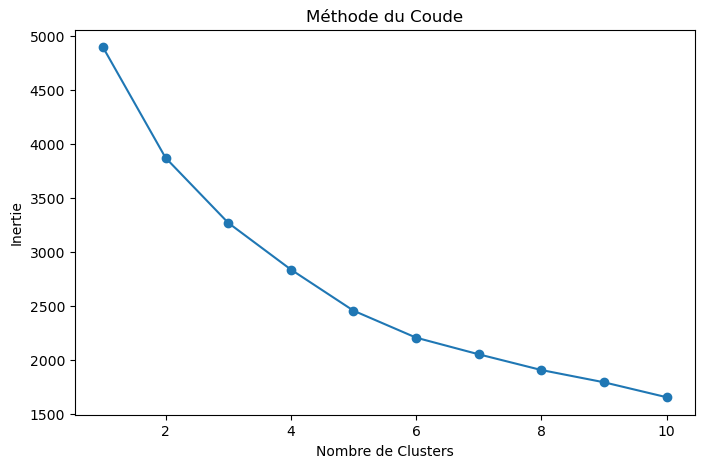

In [32]:
# Méthode du coude
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(numerical_data)
    inertia.append(kmeans.inertia_)

# Visualisation
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Méthode du Coude")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Inertie")
plt.show()

Le graphique montre l'inertie en fonction du nombre de clusters, allant de 1 à 10.
Il y a une forte diminution de l'inertie entre 1 et 3 clusters, ce qui indique que passer de 1 à 3 clusters améliore significativement la qualité du clustering.
Un "coude" assez visible se forme autour de 3-4 clusters. Après ce point, la diminution de l'inertie devient plus graduelle et linéaire.
À partir de 4 clusters, l'ajout de nouveaux clusters n'apporte qu'une amélioration marginale (la courbe s'aplatit).

## Partie 3 : Visualisation des Données

### 3.1 - Histogrammes et Boxplots

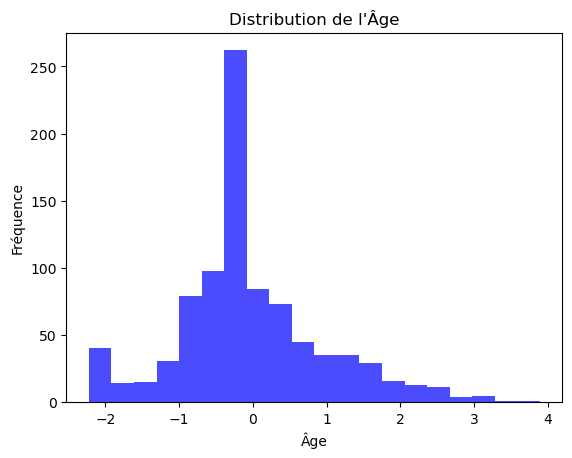

In [33]:
#Histogramme de la distribution de l'âge
plt.hist(df_titanic['age'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution de l'Âge")
plt.xlabel("Âge")
plt.ylabel("Fréquence")
plt.show()

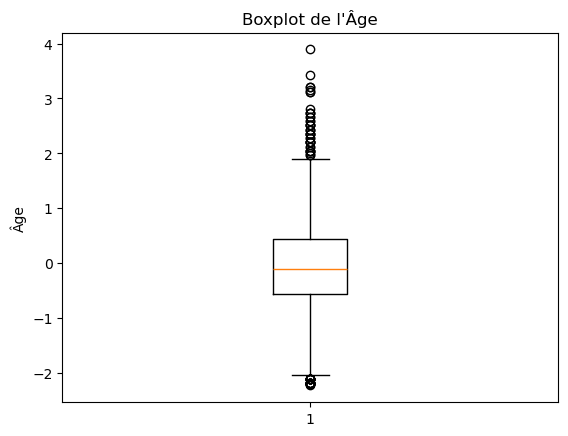

In [34]:
# Boxplot
plt.boxplot(df_titanic['age'].dropna())
plt.title("Boxplot de l'Âge")
plt.ylabel("Âge")
plt.show()

Ces deux représentations complémentaires nous donnent une image claire de la structure d'âge des passagers du Titanic : une population majoritairement d'âge moyen (30 ans), avec quelques cas notables de passagers plus âgés et très jeunes, créant ainsi une distribution légèrement asymétrique mais globalement centrée

### 3.2 - Visualisation 2D des Clusters

In [35]:
### Reduction de dimensions des données avec PCA.

In [36]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numerical_data)

In [37]:
pca_result

array([[ 0.25321095, -0.96655858],
       [ 0.58831247,  1.26645313],
       [-0.46214517, -0.48668491],
       ...,
       [ 1.31178337, -0.23653404],
       [-0.63446862,  0.05891277],
       [-0.99570311, -0.41532798]])

In [38]:
# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(numerical_data)

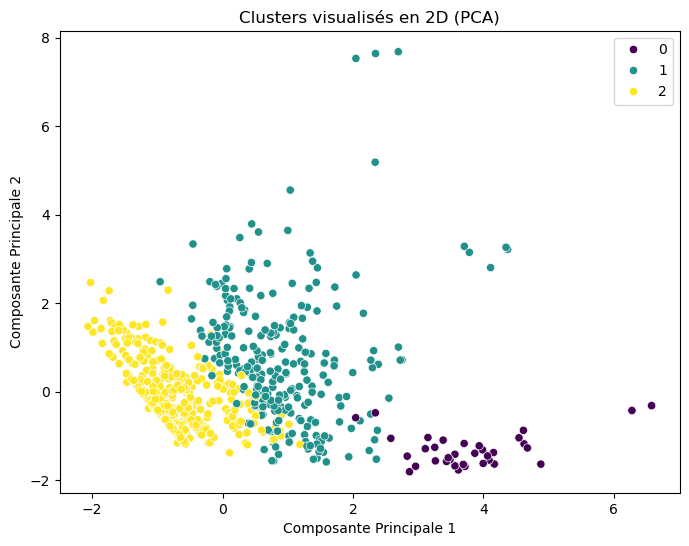

In [39]:
# Visualisation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='viridis')
plt.title("Clusters visualisés en 2D (PCA)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.show()

Composante Principale 1 :
sibsp         0.712640
parch         0.407114
age          -0.335250
fare          0.299650
alone        -0.269043
adult_male   -0.181657
sex          -0.119532
survived      0.064122
pclass_2     -0.016930
embarked_Q   -0.011716
pclass_3      0.003429
embarked_S    0.000893
Name: PC1, dtype: float64

Composante Principale 2 :
fare          0.727112
age           0.595065
pclass_3     -0.271386
survived      0.120999
sibsp        -0.107407
sex          -0.077603
embarked_S   -0.061254
parch         0.054123
alone        -0.051561
adult_male   -0.032622
embarked_Q   -0.030496
pclass_2      0.004698
Name: PC2, dtype: float64


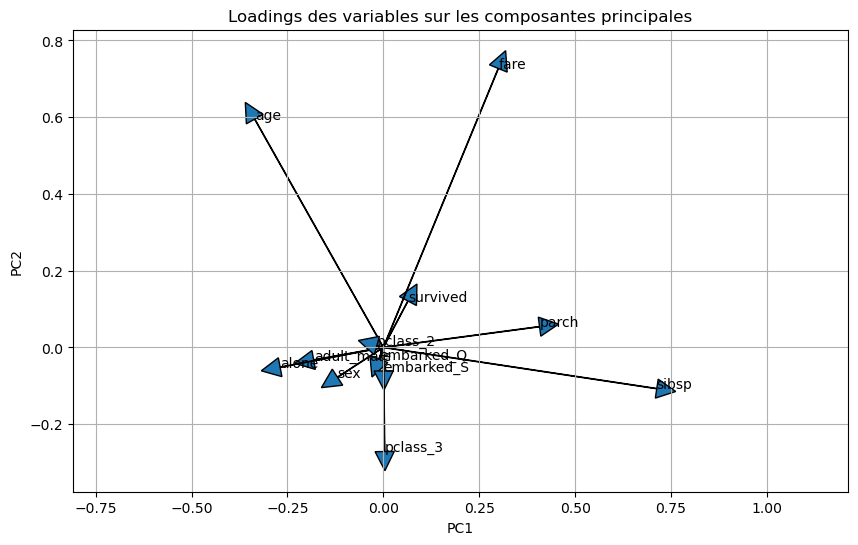

In [40]:
# Obtenir les coefficients des composantes principales
components = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=numerical_data.columns
)

# Afficher les coefficients triés par importance absolue pour chaque composante
print("Composante Principale 1 :")
print(components['PC1'].sort_values(key=abs, ascending=False))
print("\nComposante Principale 2 :")
print(components['PC2'].sort_values(key=abs, ascending=False))

# Visualisation des loadings
plt.figure(figsize=(10, 6))
for i, feature in enumerate(numerical_data.columns):
    plt.arrow(0, 0, components.iloc[i, 0], components.iloc[i, 1],
              head_width=0.05, head_length=0.05)
    plt.text(components.iloc[i, 0], components.iloc[i, 1], feature)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Loadings des variables sur les composantes principales')
plt.grid(True)
plt.axis('equal')
plt.show()

**Interprétation**
 - Composante Principale 1 (PC1) : Principalement influencée par les relations familiales (parch et sibsp avec des coefficients élevés).
Les passagers voyageant en famille ont des valeurs positives sur cet axe, tandis que les passagers seuls et plus âgés ont des valeurs négatives.

- Composante Principale 2 (PC2) : Fortement influencée par le tarif (fare) et l’âge (age). Les valeurs élevées correspondent à des passagers plus âgés ayant payé des tarifs élevés. Les passagers de troisième classe ont des valeurs négatives sur cet axe.

- Les clusters révèlent des regroupements cohérents avec l’histoire du Titanic :
    - Les familles de classe moyenne à faible (cluster jaune) ont des caractéristiques similaires et un potentiel de survie moyen.
    - Les passagers aisés (cluster turquoise) avaient des chances de survie plus élevées.
    - Les jeunes hommes seuls de troisième classe (cluster violet) étaient les plus vulnérables.

## Partie 4 : Modélisation Prédictive

### Classification

In [41]:
# Variables indépendantes et cible
X = df_titanic.drop(['survived'], axis=1)  # Remplacez 'Survived' par votre colonne cible
y = df_titanic['survived']

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle de classification
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       157
           1       0.74      0.70      0.72       111

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.77      0.78      0.78       268



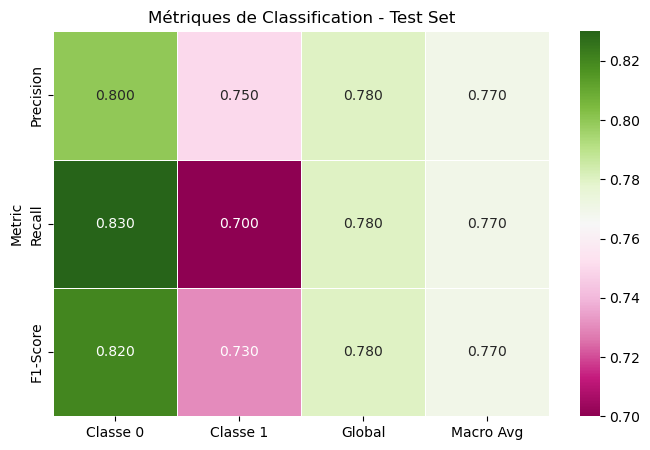

In [44]:
# Création du DataFrame pour les métriques
metrics_data = {
    "Metric": ["Precision", "Recall", "F1-Score"],
    "Classe 0": [0.80, 0.83, 0.82],
    "Classe 1": [0.75, 0.70, 0.73],
    "Global": [0.78, 0.78, 0.78],  # Weighted avg et accuracy
    "Macro Avg": [0.77, 0.77, 0.77]
}

df_metrics = pd.DataFrame(metrics_data)

# Affichage de la heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_metrics.set_index("Metric"), annot=True, fmt=".3f", cmap="PiYG", linewidths=0.5, cbar=True)
#sns.heatmap(df_metrics, annot=True, cmap="YlOrRd", fmt=".3f", linewidths=0.5)
plt.title("Métriques de Classification - Test Set")
plt.show()

**Analyse des Métriques**
- Précision (Precision) : Proportion de passagers classés comme survivants qui ont réellement survécu.
    - Classe 0 : 80 % des passagers prédits comme décédés le sont réellement.
    - Classe 1 : 75 % des passagers prédits comme survivants le sont réellement.
- Rappel (Recall) : Proportion des survivants réellement détectés par le modèle.
    - Classe 0 : 83 % des passagers décédés sont bien identifiés.
    - Classe 1 : 70 % des survivants sont moins bien identifiés.
- F1-score : Moyenne harmonique entre précision et rappel.
    - Classe 0 : 0.82 → Bonne performance globale pour identifier les passagers décédés.
    - Classe 1 : 0.73 → Performance un peu plus faible pour identifier les survivants.
- Accuracy (Exactitude globale) : **78%** Le modèle classe correctement environ 78 % des passagers.